In [1]:
from graphnics import *
from fenics import *
from xii import *
import sys
sys.path.append('../graphnics/data')
from generate_arterial_tree import *
import vasomotion as vm
import imp
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/block/__init__.py:15: UserWarning: The cbc.block repository has moved to https://github.com/blocknics/cbc.block
  warnings.warn('The cbc.block repository has moved to https://github.com/blocknics/cbc.block', UserWarning)


Missing HsMG for fract norm computing


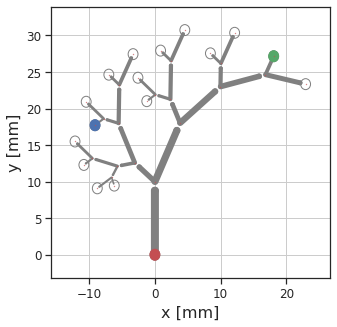

In [2]:
# Make domain 

from generate_arterial_tree import make_arterial_tree
directions = [1,1]*100

radius0 = 1
eps = 0.1

G = make_arterial_tree(N=5, radius0=radius0, L0=10, directions=directions, gam=0.75, remove_overlapping_edges=False)

markers = ['r', 'b', 'g']

nodes = [list(G.nodes())[ix] for ix in [0, 20,30]]
pos = [G.nodes()[n]['pos'] for n in nodes]

sns.set(style='white')
imp.reload(vm)
fig, ax = vm.plot_tree(G)

leaf_nodes = [n for n in G.nodes() if G.degree(n) == 1]
poss = [G.nodes()[n]['pos'] for n in leaf_nodes]


circles = [plt.Circle(p, 0.75, color='gray', fill=False) for p in poss]
for c in circles: ax.add_patch(c)
circles = [plt.Circle(pos[i], 0.75, color=c) for i, c in enumerate(markers)]
for c in circles: ax.add_patch(c)
plt.savefig('tree.png', dpi=300, bbox_inches='tight')

G.make_mesh(3)

In [3]:
imp.reload(vm)
for e in G.edges():
    G.edges()[e]['radius1'] = G.edges()[e]['radius']
    G.edges()[e]['radius2'] = 3*G.edges()[e]['radius']
    G.edges()[e]['beta'] = 3
    G.edges()[e]['fixed'] = False


In [5]:
k = DOLFIN_EPS
freq = 1
tsteps_per_cycle = 40
n_cycles = 20

In [6]:
qps = vm.vasomotion_simulation(G, freq=freq, n_cycles=n_cycles, tsteps_per_cycle=tsteps_per_cycle, epsilon=eps)    

Starting simulation
Solving...


100%|██████████| 799/799 [02:48<00:00,  4.75it/s]


In [7]:
print(f' $i$     &   $\langle Q \\rangle$    \\\\ \n')

    
# Compute net flow from simulation
yss = []
tss = []

nodes = [n for n in G.nodes() if G.degree(n) == 1]
poss = [G.nodes()[n]['pos'] for n in G.nodes()]


for i, n in enumerate(nodes):
    outflows = [sol[0](poss[i]) for sol in qps]
    
    # plot over time
    time_steps = len(qps)
    T = n_cycles/freq # total simulation time
    dt = T/time_steps
    
    ys = np.cumsum(outflows[5*tsteps_per_cycle:])*dt
    ts = np.linspace(0, T, time_steps)[5*tsteps_per_cycle:]
    ts -= ts[0]
    
    # we compute using the last cycle, need to know how many time steps to slice through
    T_cycle = 1.0/freq
    tsteps_per_cycle_for_this_freq = int(T_cycle/dt)
    
    Qh_avg_tilde = (ys[-1]-ys[-tsteps_per_cycle_for_this_freq-1])/T_cycle
    
    tss.append(ts)
    yss.append(ys)
    
    print(f'{i}  {n}    &  {Qh_avg_tilde:<1.3e} \\\\' )

 $i$     &   $\langle Q \rangle$    \\ 

0  0    &  6.784e-01 \\
1  16    &  7.212e-01 \\
2  17    &  1.802e-01 \\
3  18    &  4.106e-01 \\
4  19    &  9.459e-02 \\
5  20    &  1.822e-01 \\
6  21    &  3.091e-01 \\
7  22    &  1.334e-01 \\
8  23    &  5.120e-02 \\
9  24    &  4.298e-02 \\
10  25    &  6.728e-02 \\
11  26    &  7.671e-02 \\
12  27    &  8.449e-02 \\
13  28    &  1.394e-01 \\
14  29    &  1.497e-01 \\
15  30    &  -6.102e-02 \\
16  31    &  3.807e-02 \\


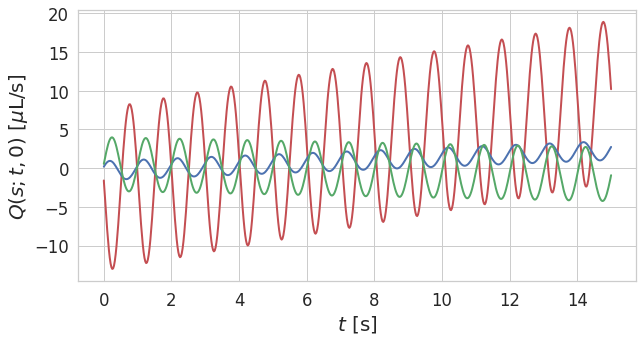

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10,5)) 
sns.set(font_scale=1.5, style='whitegrid')

n_ixs = [0, 5, 15]
nodes = [0,20,30]

for ix, i in enumerate(n_ixs):
    
    ax.plot(tss[i], yss[i], color=markers[ix], linewidth=2, label=i)

    ax.set_ylabel('$Q(s;t,0)$ [$\mu$L/s]', fontsize=20)
    ax.set_xlabel('$t$ [s]', fontsize=20)
    
#plt.legend()

plt.savefig('flow.png', bbox_inches='tight', dpi=300)